<a href="https://colab.research.google.com/github/sheldonkemper/portfolio/blob/main/CAM_DS_301_Hybrid_techniques_Demo_8_2_1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Demonstration 8.2.1 Hybrid techniques for time series forecasting

Hybrid models that integrate classical time series forecasting techniques like ARIMA or SARIMA with machine learning models such as LightGBM or XGBoost represent a sophisticated approach to predictive modelling. These models leverage the strengths of both statistical methods and modern machine learning techniques to improve forecasting accuracy and robustness.

**Strategy 1: Sequential approach**

In this first part of the demonstration, we will use a sequential combination approach. In this approach, the output from a statistical model (residuals from a SARIMA model) is used as the input for a machine learning model (XGBoost). The goal is to use the statistical model to capture linear relationships and known seasonal patterns, while the machine learning model is employed to capture complex non-linear interactions that the statistical model may overlook.

In [ ]:
#Import the common libraries.
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
!pip install sktime==0.28.0
!pip install pmdarima

import pmdarima as pm
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
pd.set_option('display.width', None)

In [ ]:
# Load the data set from sktime.
from sktime.datasets import load_airline
airline_df = load_airline()

In [ ]:
# Check the data.
airline_df.head()

,Number of airline passengers
Period,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


In [ ]:
# Convert the series into a DataFrame.
data = {
          'Month': airline_df.index,
          'AirPassengers': airline_df.values
        }
airline_df = pd.DataFrame(data)
airline_df.head()

,Month,AirPassengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [ ]:
# Set "Month" column as index.
airline_df_month = airline_df.copy()
airline_df_month = airline_df_month.set_index('Month')

In [ ]:
airline_df_hybrid = airline_df.copy()

In [ ]:
airline_df_hybrid['Month'] = airline_df_hybrid['Month'].dt.to_timestamp()

In [ ]:
airline_df_hybrid.head()

,Month,AirPassengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [ ]:
# Define a generic function for plotting the data.
def time_series_plot(data, column_1, column_2, y_label):
  data[column_1] = pd.DatetimeIndex(data[column_1])
  ax = data.set_index(column_1).plot(figsize=(24, 8))
  plt.plot(data[column_2])
  plt.xlabel(column_1)
  plt.ylabel(y_label)
  plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Create a train-test split. The test data will be from the year 1958 to 1960.
idx_train, idx_test = train_test_split(
    airline_df_hybrid.index, test_size=24, shuffle=False,
)

In [ ]:
# Check the indices for train and test set.
print(idx_train)
print(idx_test)

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
      dtype='int64', length=120)
Index([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143],
      dtype='int64')


In [ ]:
train_input, test_input = airline_df_hybrid.loc[idx_train, :], airline_df_hybrid.loc[idx_test, :]

In [ ]:
test_input

,Month,AirPassengers
120,1959-01-01,360.0
121,1959-02-01,342.0
122,1959-03-01,406.0
123,1959-04-01,396.0
124,1959-05-01,420.0
125,1959-06-01,472.0
126,1959-07-01,548.0
127,1959-08-01,559.0
128,1959-09-01,463.0
129,1959-10-01,407.0


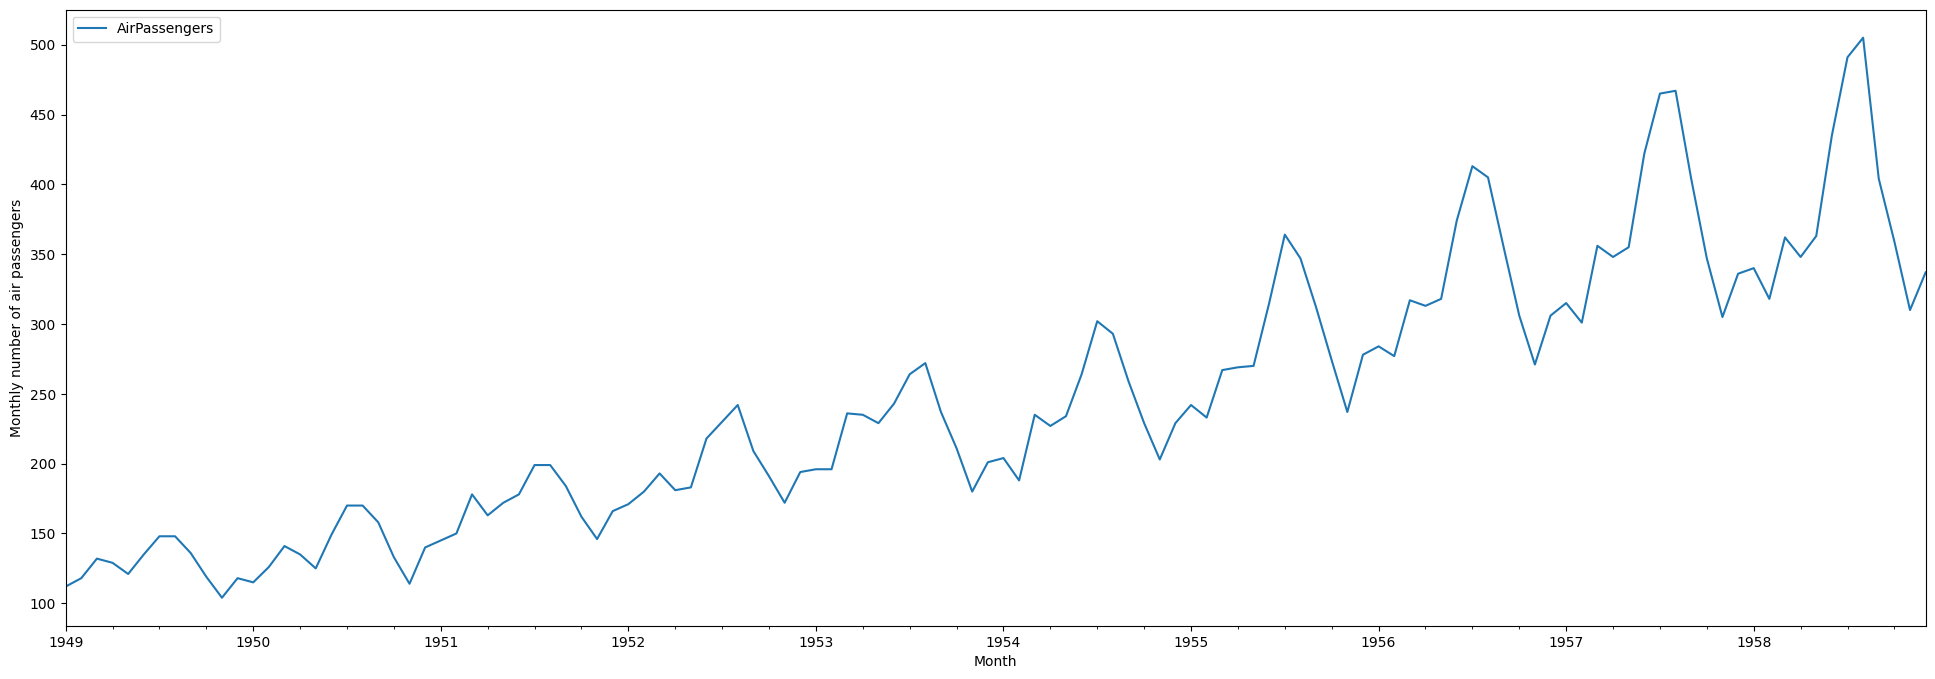

In [ ]:
time_series_plot(train_input, 'Month', 'AirPassengers', 'Monthly number of air passengers')

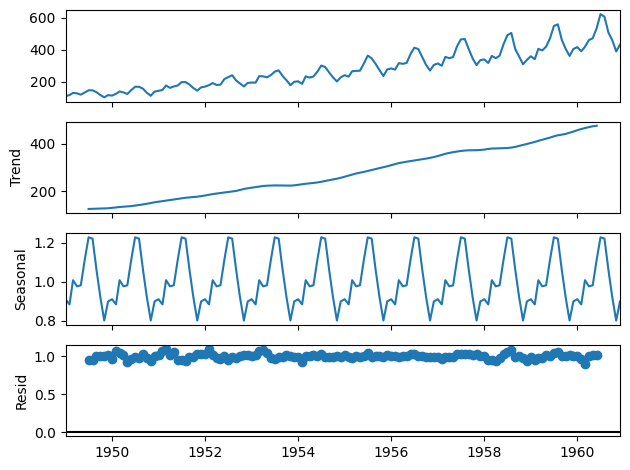

In [ ]:
data = airline_df_hybrid.copy()

data.index  #RangeIndex(start=0, stop=144, step=1)
data = data.set_index('Month')

decomposition = sm.tsa.seasonal_decompose(data, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [ ]:
train_input = train_input.set_index('Month')
test_input = test_input.set_index('Month')

In [ ]:
# Train an auto ARIMA model on the training data.
arima_model = pm.auto_arima(train_input["AirPassengers"], seasonal=True, m=12, suppress_warnings=True)
arima_model.fit(train_input["AirPassengers"])

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [ ]:
# Obtain ARIMA predictions on the training data.
y_train_pred = arima_model.predict_in_sample()

In [ ]:
# Obtain the residuals for the in-sample predictions.
residuals_train = arima_model.resid()

In [ ]:
print(pd.DataFrame({'Original Data': train_input["AirPassengers"], 'In Sample ARIMA Predict': y_train_pred, 'ARIMA Residuals': residuals_train}))

            Original Data  In Sample ARIMA Predict  ARIMA Residuals
1949-01-01          112.0                25.718013        86.281987
1949-02-01          118.0                25.737226        92.262774
1949-03-01          132.0                25.755297       106.244703
1949-04-01          129.0                25.773900       103.226100
1949-05-01          121.0                25.789246        95.210754
...                   ...                      ...              ...
1958-08-01          505.0               490.937798        14.062202
1958-09-01          404.0               438.093000       -34.093000
1958-10-01          359.0               357.176547         1.823453
1958-11-01          310.0               317.425930        -7.425930
1958-12-01          337.0               345.537793        -8.537793

[120 rows x 3 columns]


In [ ]:
def create_lag_features(y, lag=1):
    df = pd.DataFrame(y)
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df[0].shift(i)

    df.dropna(inplace=True)  # Drop rows with NaN values.
    return df

In [ ]:
# Create lag features for the residuals.
lag = 12
residuals_train_lagged = create_lag_features(residuals_train, lag)

### Lagged Features

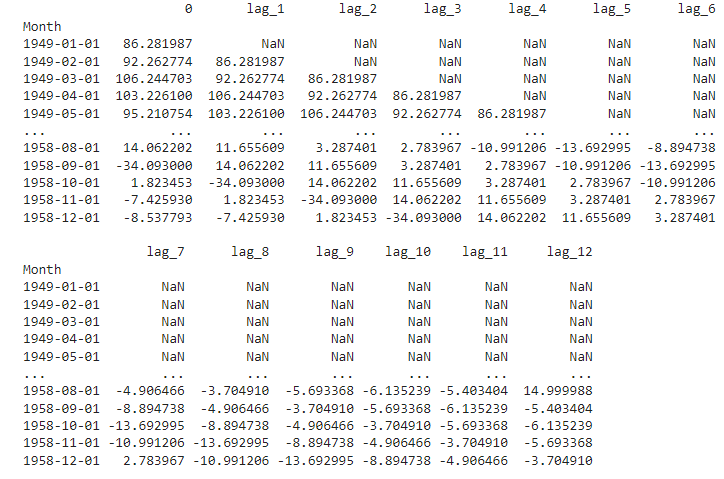

### Lagged Features after removing the Nan values

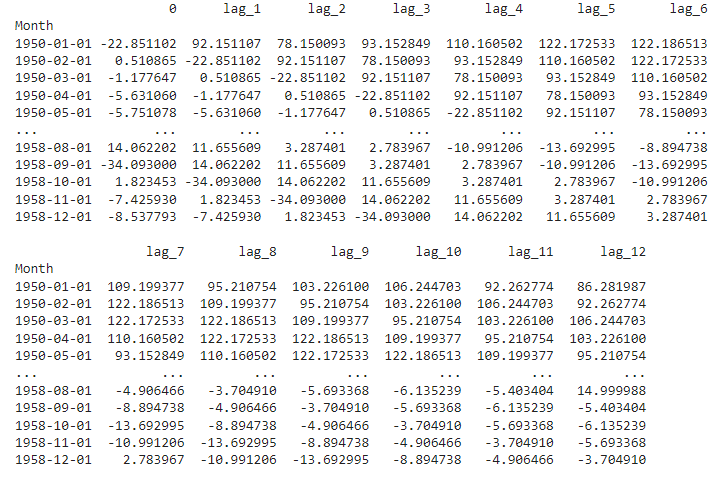

In [ ]:
# Prepare the X and y for XGBoost training.
X_train_residuals = residuals_train_lagged.drop(columns=0).values
y_train_residuals = residuals_train_lagged[0].values

In [ ]:
# Train the XGBoost model.
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
xgb_model.fit(X_train_residuals, y_train_residuals)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Forecast with ARIMA for the test period (24 steps).
arima_forecast = arima_model.predict(n_periods=len(test_input["AirPassengers"]))

In [ ]:
# Initialise the lagged residuals with the last 12 residuals from the training data.
lagged_residuals = residuals_train[-lag:].tolist()

# List to store predicted residuals.
xgb_residuals_pred = []

In [ ]:
print(lagged_residuals)

[-4.906466127771125, -8.894737963488012, -13.692995374139798, -10.991206254719657, 2.7839670679418305, 3.287401056132012, 11.655608681834849, 14.062202138217458, -34.09300003457395, 1.8234533878301704, -7.425930107283364, -8.537793201348336]


In [ ]:
# Iteratively predict the residuals using the XGBoost model.
for i in range(len(test_input["AirPassengers"])):
    # Prepare the lagged residuals as features for the next prediction
    X_new = np.array(lagged_residuals[-lag:]).reshape(1, -1)

    # Predict the next residual.
    next_residual = xgb_model.predict(X_new)[0]

    # Append the predicted residual to the list.
    xgb_residuals_pred.append(next_residual)

    # Update the lagged residuals list with the new predicted residual.
    lagged_residuals.append(next_residual)

In [ ]:
from sklearn.metrics import mean_squared_error
# Combine the ARIMA predictions and the XGBoost predicted residuals for the final forecast.
final_forecast = arima_forecast + np.array(xgb_residuals_pred)

# Calculate the mean squared error on the test set.
mse = mean_squared_error(test_input["AirPassengers"], final_forecast)
print(f"Mean Squared Error on Test Data: {mse}")

Mean Squared Error on Test Data: 2183.064915211427


In [ ]:
print(pd.DataFrame({'Original Data': test_input["AirPassengers"],'Hybrid ARIMA + XGBoost': final_forecast, 'XGBoost':xgb_residuals_pred,'ARIMA': arima_forecast}))

            Original Data  Hybrid ARIMA + XGBoost   XGBoost       ARIMA
1959-01-01          360.0              342.195625 -3.543724  345.739350
1959-02-01          342.0              321.147829 -5.186313  326.334142
1959-03-01          406.0              370.384724 -2.444225  372.828950
1959-04-01          396.0              356.990333 -3.933161  360.923494
1959-05-01          420.0              374.409471 -3.321556  377.731027
1959-06-01          472.0              454.528367  3.246542  451.281825
1959-07-01          548.0              513.655869  5.041891  508.613978
1959-08-01          559.0              519.968760 -3.789259  523.758020
1959-09-01          463.0              428.313045  4.572479  423.740566
1959-10-01          407.0              381.563084  1.978681  379.584404
1959-11-01          362.0              329.019761 -2.289356  331.309117
1959-12-01          405.0              361.701986  2.770463  358.931523
1960-01-01          417.0              366.717465 -1.487947  368

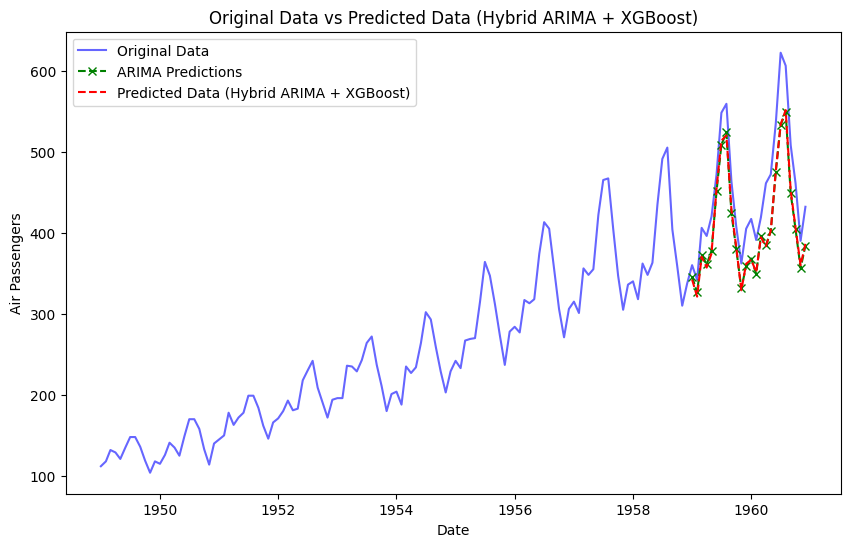

In [ ]:
import matplotlib.pyplot as plt

# Plot the original data.
plt.figure(figsize=(10, 6))
plt.plot(airline_df_hybrid['Month'], airline_df_hybrid['AirPassengers'], label="Original Data", color="blue", alpha=0.6)

# Plot the ARIMA forecast on the test set.
plt.plot(final_forecast.index, arima_forecast, label="ARIMA Predictions", color="green", linestyle="--", marker='x')

# Plot the forecasted data.
plt.plot(final_forecast.index, final_forecast.values, label="Predicted Data (Hybrid ARIMA + XGBoost)", color="red", linestyle="--")

plt.title("Original Data vs Predicted Data (Hybrid ARIMA + XGBoost)")
plt.xlabel("Date")
plt.ylabel("Air Passengers")
plt.legend()
plt.show()


**Strategy 2: Parallel approach**

In the second part of the demonstration, we employ a parallel combination of both a statistical model and a machine learning model. Each model is trained and executed independently, and their predictions are generated separately. The final output is obtained by taking a weighted average of the predictions from each model. The goal is to capitalise on the independent predictive strengths of each model, providing a balanced forecast.

In [ ]:
# Import XGBoost.
from xgboost import XGBRegressor

In [ ]:
# Load the relevant helper functions from sktime.
from sktime.forecasting.compose import (TransformedTargetForecaster, make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter, ForecastingGridSearchCV)
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

In [ ]:
airline_df_train, airline_df_test = airline_df_month.iloc[:-24], airline_df_month.iloc[-24:]

In [ ]:
# Create a pipeline with a detrender and a deseasonaliser.
def create_predictor_with_deseasonaliser_xgboost(sp=12, degree=1):

    regressor = XGBRegressor(base_score=0.5,
                      n_estimators=400,
                      min_child_weight=1,
                      max_depth=7,
                      learning_rate=0.1,
                      booster='gbtree',
                      tree_method='exact',
                      reg_alpha=0,
                      subsample=0.5,
                      validate_parameters=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      colsample_bytree=1,
                      gamma=0
                    )
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="multiplicative", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=12, strategy="recursive"),
            ),
        ]
    )

    return forecaster

In [ ]:
# Perform a grid search with cross-validation.
def grid_search_predictor(train, test, predictor, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        predictor, strategy="refit", cv=cv, param_grid=param_grid,
        scoring=MeanAbsolutePercentageError(symmetric=True)
    )
    gscv.fit(train)
    print(f"Best parameters: {gscv.best_params_}")

    # Forecasting
    future_horizon = np.arange(len(test)) + 1
    predictions = gscv.predict(fh=future_horizon)

    return predictions

In [ ]:
predictor = create_predictor_with_deseasonaliser_xgboost()

# Set window_length values to conduct a grid search.
param_grid = {"forecast__window_length": [6, 12, 18, 24, 30, 36]}

# Perform a grid search.
predictions2 = grid_search_predictor(
    airline_df_train["AirPassengers"], airline_df_test["AirPassengers"], predictor, param_grid
)

Best parameters: {'forecast__window_length': 30}


In [ ]:
# Convert predictions1's DatetimeIndex to PeriodIndex to match predictions2.
predictions1 = arima_forecast.copy()
predictions1.index = predictions1.index.to_period('M')

# Combine the predictions using a weighted average.
combined_pred = 0.5 * predictions1 + 0.5 * predictions2

# Display the combined predictions.
print(combined_pred)

1959-01    345.986056
1959-02    335.883621
1959-03    385.964200
1959-04    373.655440
1959-05    382.859468
1959-06    450.288590
1959-07    514.717070
1959-08    527.449601
1959-09    444.010889
1959-10    391.198329
1959-11    337.997964
1959-12    374.971018
1960-01    374.114273
1960-02    361.515290
1960-03    413.555483
1960-04    400.709424
1960-05    410.064586
1960-06    478.853918
1960-07    535.229746
1960-08    556.702997
1960-09    481.457398
1960-10    418.086669
1960-11    360.400163
1960-12    394.631729
Freq: M, dtype: float64


In [ ]:
# Convert the PeriodIndex to DatetimeIndex for plotting.
combined_pred.index = combined_pred.index.to_timestamp()

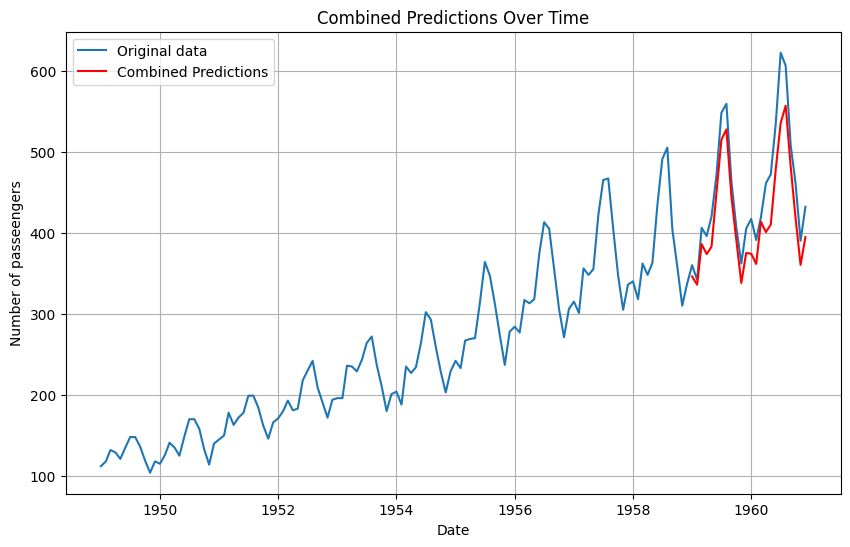

In [ ]:
# Plot the combined predictions.
plt.figure(figsize=(10, 6))
plt.plot(data["AirPassengers"], label = 'Original data', color='#1f76b4')
plt.plot(combined_pred, label='Combined Predictions', color = 'red')
plt.title('Combined Predictions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of passeengers')
plt.legend()
plt.grid(True)
plt.show()

# Key information

In this demonstration, you learned how to effectively combine a classical time series model with a machine learning model to potentially improve forecasting accuracy. These hybrid approaches are increasingly gaining in popularity and acceptance.

## Reflect

What are the practical applications of these techniques?

> Select the pen to edit and add your comments.